In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta
from scipy.special import logit

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

# Finding an example

In [13]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 1000

CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

In [11]:
my_dist = np.random.uniform
my_params = (0, 1)
matrix_generator = matrix_gen.MatrixGenerator(
    my_dist, my_params, N, N_INTVS
)
pofs = []

success_count = 0
while success_count < N_EXPERIMENTS:
    print(success_count)
    
    (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
        round_=False
    )
    
    _, counts = np.unique(sorted_increase_matrix[sorted_increase_matrix > 0], return_counts=True)
    if np.any(counts > 1):
        continue
        
    
    # Leximin on un-norm costs
    lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
        sorted_matrix, CAPACITIES
    )
    lex_assignments = lex_assigner.solve()
    lex_cost1 = lex_assigner.get_cost(
        lex_assignments, cost_matrix=sorted_matrix
    )
    
    # Leximin on norm costs
    lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
        sorted_increase_matrix, CAPACITIES
    )
    lex_assignments = lex_assigner.solve()
    lex_cost2 = lex_assigner.get_cost(
        lex_assignments, cost_matrix=sorted_matrix
    )
    
    
    pofs.append(lex_cost1 / lex_cost2)
    success_count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

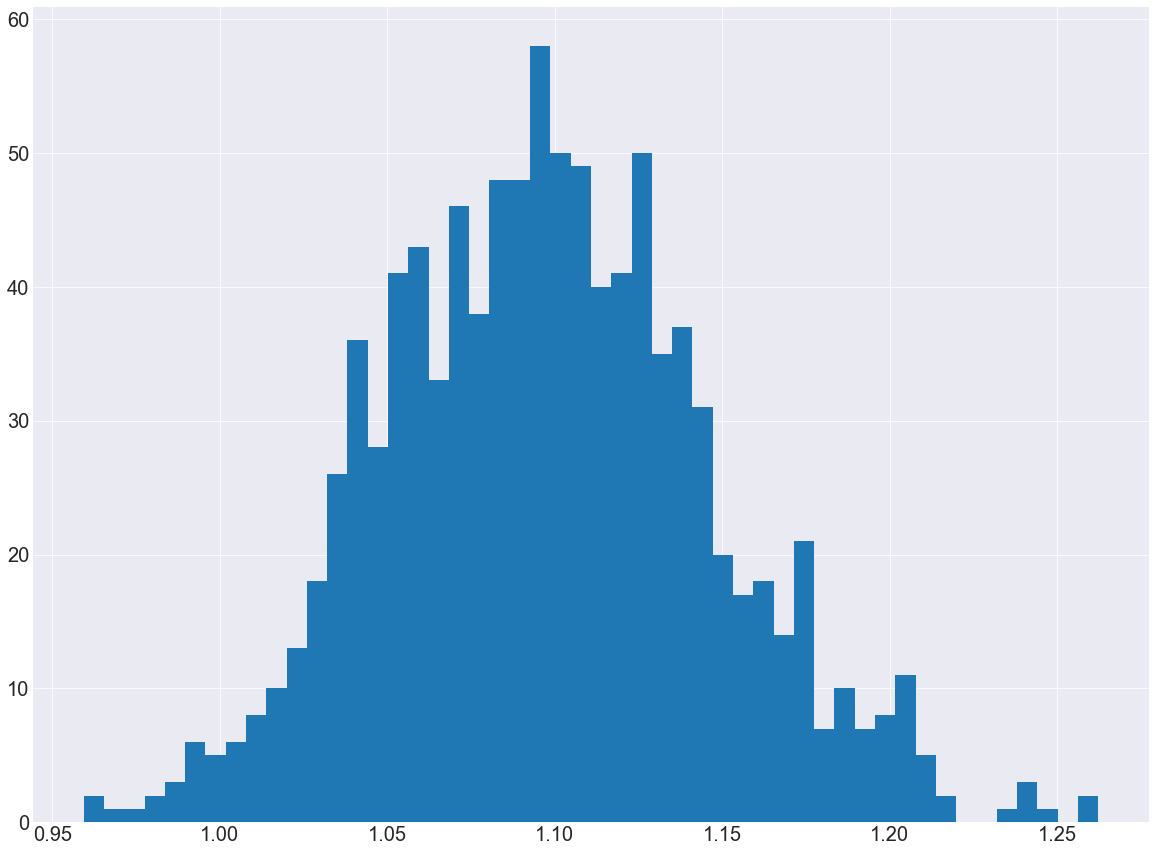

In [12]:
plt.hist(pofs, bins=50)
plt.show()

# Search for examples

In [14]:
N = 3
N_INTVS = 3

CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

In [16]:
my_dist = np.random.uniform
my_params = (0, 1)
matrix_generator = matrix_gen.MatrixGenerator(
    my_dist, my_params, N, N_INTVS
)

while True:
    (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
        round_=False
    )
    
    _, counts = np.unique(sorted_increase_matrix[sorted_increase_matrix > 0], return_counts=True)
    if np.any(counts > 1):
        continue
        
    
    # Leximin on un-norm costs
    lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
        sorted_matrix, CAPACITIES
    )
    lex_assignments1 = lex_assigner.solve()
    lex_cost1 = lex_assigner.get_cost(
        lex_assignments1, cost_matrix=sorted_matrix
    )
    
    # Leximin on norm costs
    lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
        sorted_increase_matrix, CAPACITIES
    )
    lex_assignments2 = lex_assigner.solve()
    lex_cost2 = lex_assigner.get_cost(
        lex_assignments2, cost_matrix=sorted_matrix
    )
    
    
    if lex_cost1 < lex_cost2:
        break

In [17]:
sorted_matrix

array([[0.28072248, 0.66983072, 0.87684935],
       [0.11666112, 0.44494808, 0.49878159],
       [0.37578665, 0.37594123, 0.75119589]])

In [18]:
sorted_increase_matrix

array([[0.00000000e+00, 3.89108240e-01, 5.96126871e-01],
       [0.00000000e+00, 3.28286952e-01, 3.82120462e-01],
       [0.00000000e+00, 1.54580073e-04, 3.75409241e-01]])

In [19]:
print(lex_assignments1)
print(lex_cost1)

[0 2 1]
1.15544529566267


In [20]:
print(lex_assignments2)
print(lex_cost2)

[0 1 2]
1.4768664462682752


second agent: small starting cost (in the first col) and small increase from 2nd to 3rd col
third agent: large starting cost and large increase from 2nd to 3rd col, but (relatively) small increase from 1st to 3rd col

# Verifying upper-bounds for ratio

## C(L_n) / C(L_u)

In [19]:
N = 30

epsilon = 0.00001
# delta = 0.0001
delta = epsilon

# First row
matrix = [[1 - 2 * epsilon] * N]
matrix[0][0] = 0
matrix[0][N - 1] = 1 - epsilon

for row_id in range(1, N):
    # temp_row = [0] * (N - row_id) + [1 - (N - row_id + 1) * delta] * row_id
    temp_row = [(N - row_id + 1) * delta] * (N - row_id) + [1] * row_id
    matrix.append(temp_row)

matrix = np.array(matrix)
increase_matrix = matrix - np.repeat(
    matrix[:, 0], N
).reshape((N, N))

print(matrix)
print()
print(increase_matrix)

[[0.0000e+00 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01
  9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01
  9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01
  9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01
  9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9998e-01 9.9999e-01]
 [3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04
  3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04
  3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04
  3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04
  3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 3.0000e-04 1.0000e+00]
 [2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04
  2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04
  2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04
  2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04
  2.9000e-04 2.9000e-04 2.9000e-04 2.9000e-04 

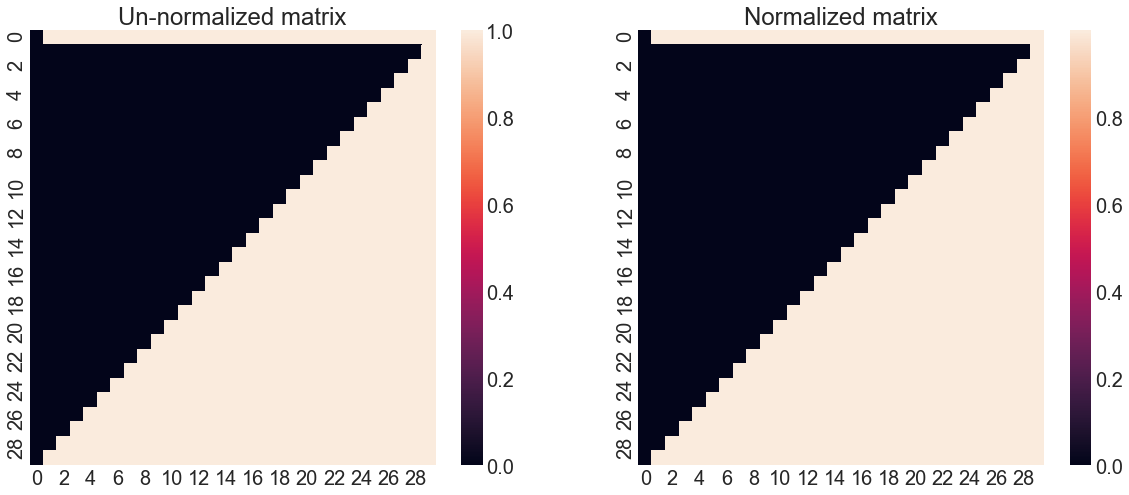

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(matrix, ax=ax[0])
sns.heatmap(increase_matrix,ax=ax[1])

ax[0].set_title('Un-normalized matrix')
ax[1].set_title('Normalized matrix')

plt.show()

In [20]:
lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
    matrix, np.ones((N,)).astype(int)
)
lex_u_assignments = lex_u_assigner.solve()
lex_u_cost = lex_u_assigner.get_cost(
    lex_u_assignments, cost_matrix=matrix
)

print(lex_u_assignments)
print(lex_u_cost)

[29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1  0]
1.0046300000000001


In [21]:
lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
    increase_matrix, np.ones((N,)).astype(int)
)
lex_n_assignments = lex_n_assigner.solve()
lex_n_cost = lex_n_assigner.get_cost(
    lex_n_assignments, cost_matrix=matrix
)

print(lex_n_assignments)
print(lex_n_cost)

[ 1 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7
  6  5  4  3  2  0]
29.0


In [22]:
lex_n_cost / lex_u_cost, N - 1

(28.866348805032693, 29)

## C(L_u) / C(L_n)

In [26]:
matrix = []

for row_id in range(N):
    temp_row = [0] * (N - row_id - 1) + [1 - epsilon] + [1] * row_id
    matrix.append(temp_row)
    
matrix = np.array(matrix)
increase_matrix = matrix - np.repeat(
    matrix[:, 0], N
).reshape((N, N))

print(matrix)
print()
print(increase_matrix)

[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.99999]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.99999 1.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.99999 1.      1.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.99999
  1.      1.      1.     ]
 [0.      0.      0.      0.      0.      0.      0.      0

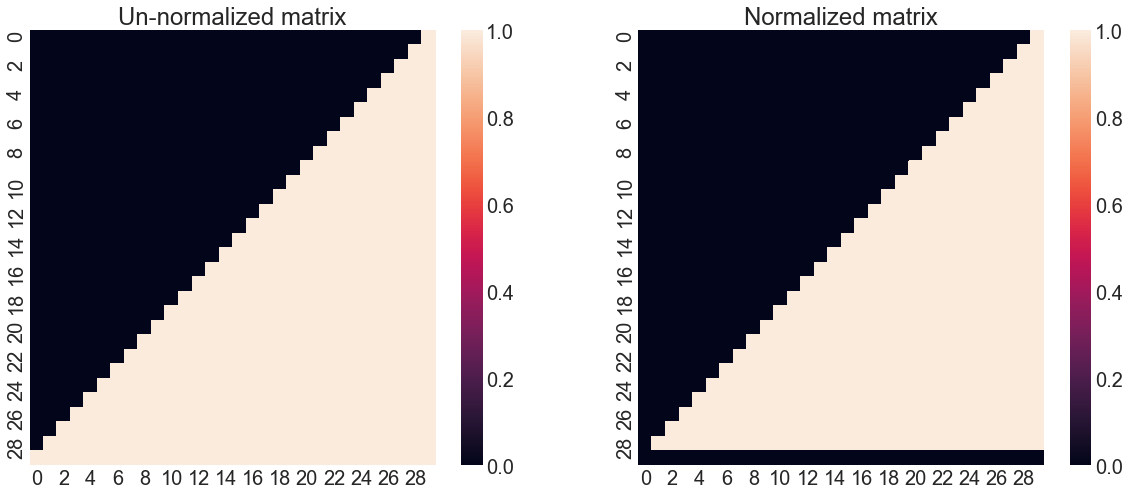

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(matrix, ax=ax[0])
sns.heatmap(increase_matrix,ax=ax[1])

ax[0].set_title('Un-normalized matrix')
ax[1].set_title('Normalized matrix')

plt.show()

In [28]:
lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
    matrix, np.ones((N,)).astype(int)
)
lex_u_assignments = lex_u_assigner.solve()
lex_u_cost = lex_u_assigner.get_cost(
    lex_u_assignments, cost_matrix=matrix
)

print(lex_u_assignments)
print(lex_u_cost)

[29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1  0]
29.999700000000008


In [29]:
lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
    increase_matrix, np.ones((N,)).astype(int)
)
lex_n_assignments = lex_n_assigner.solve()
lex_n_cost = lex_n_assigner.get_cost(
    lex_n_assignments, cost_matrix=matrix
)

print(lex_n_assignments)
print(lex_n_cost)

[28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5
  4  3  2  1  0 29]
1.0


In [31]:
lex_u_cost / lex_n_cost, N

(29.999700000000008, 30)